In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

In [40]:
df_month = pd.read_csv("dataset/filtered_data.csv")
df_month.set_index('Data e Hora', drop=True, inplace=True)
df_month.index = pd.to_datetime(df_month.index)

df_month= df_month.resample('M').sum()[['producao_renovavel']]

split_index = int(len(df_month) * 0.8)

df_month_train = np.log(df_month[:split_index])
df_month_test = np.log(df_month[split_index:])
print(df_month_train.tail())
print(df_month_test.head())

             producao_renovavel
Data e Hora                    
2021-12-31             8.009099
2022-01-31             7.869253
2022-02-28             7.461019
2022-03-31             7.910323
2022-04-30             7.798283
             producao_renovavel
Data e Hora                    
2022-05-31             7.619019
2022-06-30             7.429195
2022-07-31             7.442145
2022-08-31             7.378154
2022-09-30             7.577259


C:\Users\User01\AppData\Local\Temp\ipykernel_17800\2635169396.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_month= df_month.resample('M').sum()[['producao_renovavel']]


c:\Users\User01\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\User01\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error Percentage (MAEP): 6.42%


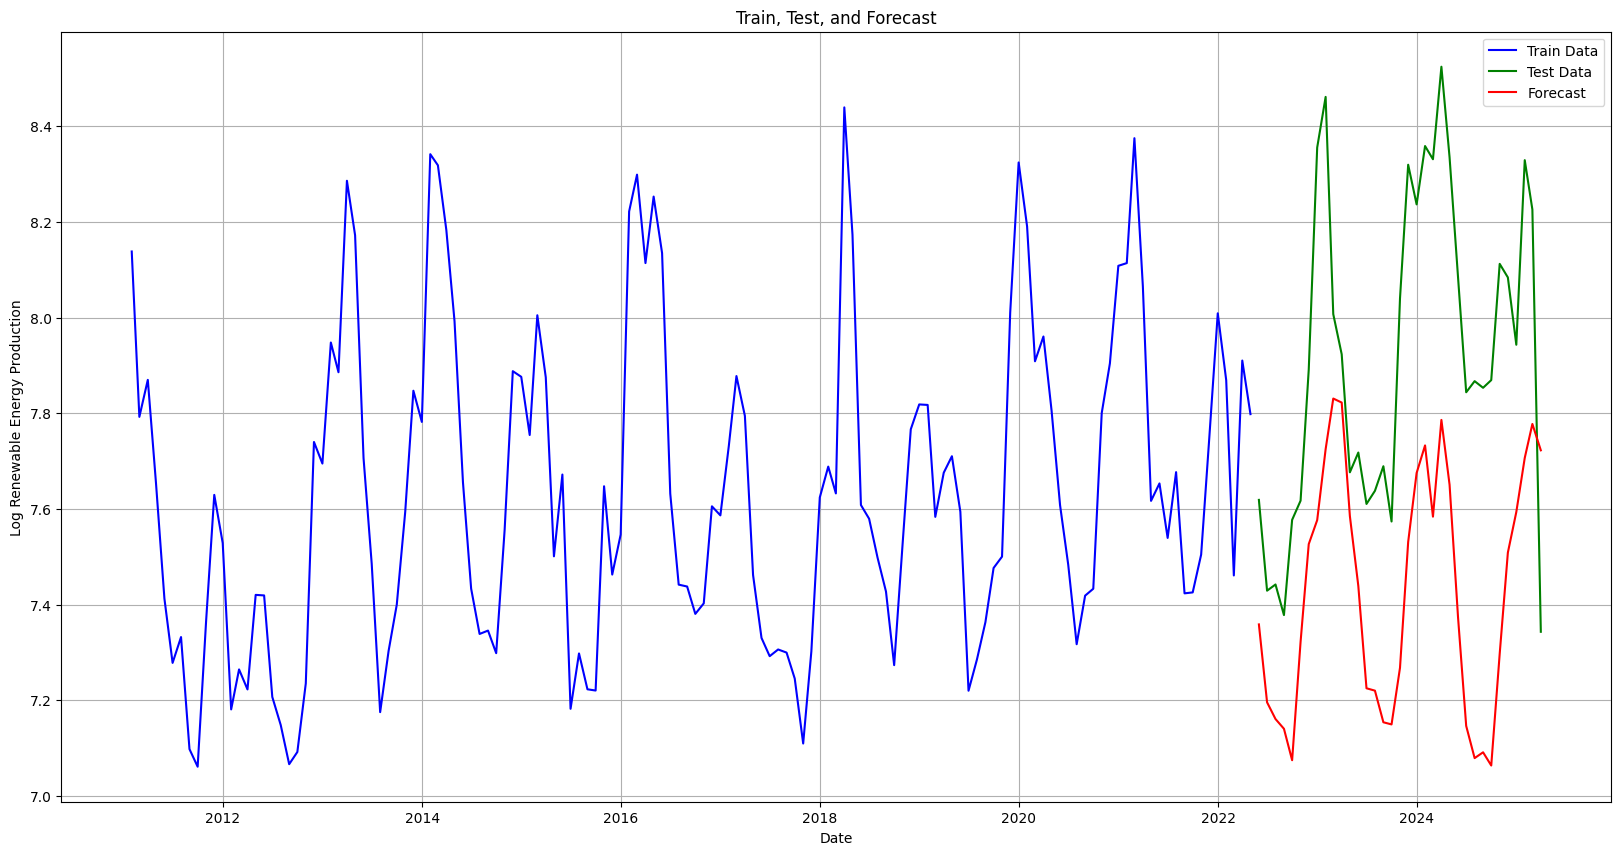

In [ ]:

# Define the parameter ranges for grid search
p = q = range(1, 6)  # Non-seasonal parameters
P = Q = range(1,6)  # Seasonal parameters
d = D = 1  # Fixed differencing orders
m = [12]  # Seasonal period (e.g., yearly data)

# Generate all combinations of parameters
param_combinations = list(itertools.product(p, [d], q))
seasonal_param_combinations = list(itertools.product(P, [D], Q, m))

total_iterations = len(param_combinations) * len(seasonal_param_combinations)
completed_iterations = 0

# Initialize variables to store the best model and its parameters
best_aic = float("inf")
best_params = None
best_seasonal_params = None
best_model = None

# Perform grid search
for params in param_combinations:
    for seasonal_params in seasonal_param_combinations:
        try:
            # Define and fit the SARIMA model
            model = SARIMAX(df_month_train, 
                            order=params, 
                            seasonal_order=seasonal_params, 
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
            fitted_model = model.fit(disp=False)
            
            # Check if the current model has the lowest AIC
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_params = params
                best_seasonal_params = seasonal_params
                best_model = fitted_model
        except Exception as e:
            pass  # Continue if an error occurs
        
        # Update progress
        completed_iterations += 1
        print(f"Progress: {completed_iterations}/{total_iterations} ({(completed_iterations/total_iterations)*100:.2f}%)")

# Print the best parameters and AIC
print(f"Best SARIMA Model: Order={best_params}, Seasonal Order={best_seasonal_params}, AIC={best_aic}")

# Forecast using the best model
forecast = best_model.forecast(steps=len(df_month_test))

# Plot the results
plt.figure(figsize=(20, 7))
plt.plot(df_month_train.index, df_month_train, label='Training Data', color='blue')
plt.plot(df_month_test.index, df_month_test.values, label='Testing Data', color='green')
plt.plot(df_month_test.index, forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Model Forecast (Grid Search)')
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# Calculate Mean Absolute Error Percentage (MAEP)
maep = np.mean(np.abs((df_month_test.values.flatten() - forecast.values) / df_month_test.values.flatten())) * 100
print(f"Mean Absolute Error Percentage (MAEP): {maep:.2f}%")

# Read the existing data from the JSON file
try:
    with open("sarima_results.json", "r") as json_file:
        data = json.load(json_file)
except (FileNotFoundError, json.JSONDecodeError):
    data = []  # Initialize an empty list if the file doesn't exist or is empty

# Add a new entry to the list
new_entry = {
    "params": {
        "order": best_params,
        "seasonal_order": best_seasonal_params
    },
    "maep": float(maep),
    "forecast_length": len(forecast)
}
data.append(new_entry)

# Save the updated list back to the JSON file
with open("sarima_results.json", "w") as json_file:
    json.dump(data, json_file, indent=4)

print("New entry added to sarima_results.json")

Mean Absolute Error Percentage (MAEP): 5.75%


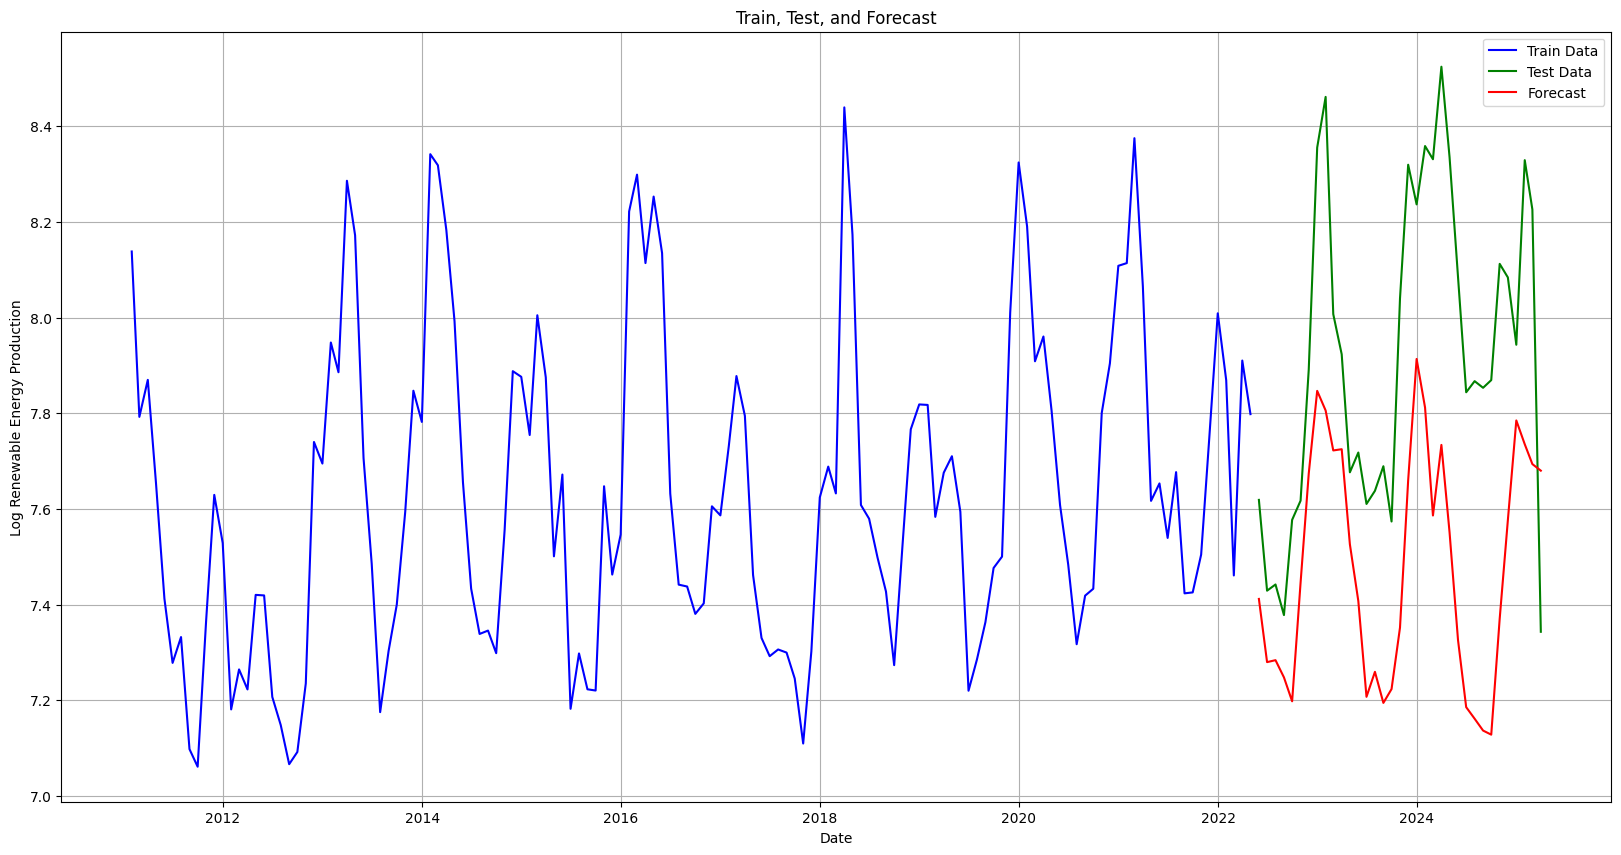

In [ ]:
# # Define parameters
# order = (2, 1, 1)
# seasonal_order = (3, 1, 4, 12)

# # Create and fit the SARIMAX model
# model = SARIMAX(df_month_train, 
#                 order=order, 
#                 seasonal_order=seasonal_order, 
#                 enforce_stationarity=False, 
#                 enforce_invertibility=False)
# fitted_model = model.fit(disp=False)

# # Forecast
# forecast = fitted_model.forecast(steps=len(df_month_test))

# # Calculate Mean Absolute Error Percentage (MAEP)
# maep = np.mean(np.abs((df_month_test.values.flatten() - forecast.values) / df_month_test.values.flatten())) * 100
# print(f"Mean Absolute Error Percentage (MAEP): {maep:.2f}%")

# # Plot the results
# plt.figure(figsize=(20, 10))

# # Plot train data
# plt.plot(df_month_train.index, df_month_train['producao_renovavel'], label='Train Data', color='blue')

# # Plot test data
# plt.plot(df_month_test.index, df_month_test['producao_renovavel'], label='Test Data', color='green')

# # Plot forecast
# plt.plot(forecast.index, forecast.values, label='Forecast', color='red')

# # Add title and labels
# plt.title('Train, Test, and Forecast')
# plt.xlabel('Date')
# plt.ylabel('Log Renewable Energy Production')
# plt.legend()
# plt.grid()

# # Show the plot
# plt.show()

In [ ]:


# Read the existing data from the JSON file
try:
    with open("sarima_results.json", "r") as json_file:
        data = json.load(json_file)
except (FileNotFoundError, json.JSONDecodeError):
    data = []  # Initialize an empty list if the file doesn't exist or is empty

# Add a new entry to the list
new_entry = {
    "params": {
        "order": order,
        "seasonal_order": seasonal_order
    },
    "maep": float(maep),
    "forecast_length": len(forecast)
}
data.append(new_entry)

# Save the updated list back to the JSON file
with open("sarima_results.json", "w") as json_file:
    json.dump(data, json_file, indent=4)

print("New entry added to sarima_results.json")


New entry added to sarima_results.json
